![](tweede_kamer.png)

De verkiezingen komen er weer aan, en de Tweede Kamer heeft een [open data portaal](https://opendata.tweedekamer.nl/). Daar heb ik fijn gebruik van gemaakt en alle moties vanaf 2009 gedownload, t/m 10 juni 2023. Het zijn er om precies te zijn 39245 en in dit blog kijk ik of er interessante inzichten uit te halen zijn.

In [241]:
#| include: false
import itertools
import pprint
import datetime
from collections import namedtuple, Counter
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import altair as alt


In [242]:
#| include: false
file = open("moties_processed_df.pickle","rb")
df = pickle.load(file)
from parameters import party_colors
print('aantal moties in dataset:', len(df))

aantal moties in dataset: 39245


In [173]:
#| include: false
# https://imagecolorpicker.com/


column_list = df.columns.values
indiener_column = [c for c in column_list if ('Indiener') in c and c != 'Indiener_persoon']
medeindiener_column = [c for c in column_list if 'Medeindiener' in c and c != 'Medeindiener_persoon']
stem_column = [c for c in column_list if 'Stem_' in c and c != 'Stem_persoon']
aantal_stemmen_column = [c for c in column_list if 'Aantal' in c]

In [174]:
#| include: false
# make a column with the indienende partij
ind = pd.melt(df, value_vars=indiener_column, ignore_index=False)
ind = ind[ind['value'] == 1]
ind = ind.rename(columns={'variable':'Indienende_partij'})
ind['Indienende_partij'] = ind['Indienende_partij'].str[9:]
df['Indiener_persoon'] = df['Indiener_persoon'].map(lambda x: x if x else '')  # this used to be lambda x: x[0] if x else ''
# df = df.join(ind['Indienende_partij'], how='left')
df['Indienende_persoon_partij'] = df['Indiener_persoon'] + ', ' + df['Indienende_partij']

In [175]:
#| include: false
def get_largest_parties(year=2020,top=False):
    tmp = df[(df['Vergaderjaar']==str(year)+'-'+str(year+1))]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index

def get_largest_parties_chamber(chamber='Rutte IV',top=False):
    tmp = df[df['Kamer']== chamber]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index

def to_vergaderjaar(year):
    return str(year) + '-' + str(year+1)

def get_stem_column(largest):
    return [c for c in column_list if 'Stem_' in c and c != 'Stem_persoon' and c[5:] in largest]
  
get_largest_parties()

Index(['VVD', 'D66', 'PVV', 'CDA', 'SP', 'GroenLinks', 'PvdA', 'ChristenUnie',
       'PvdD', 'FVD', 'SGP', 'JA21', 'Groep Van Haga', 'DENK', 'Volt',
       'Van Haga', 'Van Kooten-Arissen', 'BBB', 'Omtzigt', 'BIJ1',
       'Fractie Den Haan', 'Krol'],
      dtype='object')

In [176]:
#| include: false
get_largest_parties_chamber("Rutte IV", 16)

Index(['VVD', 'D66', 'PVV', 'CDA', 'SP', 'PvdA', 'GroenLinks', 'PvdD', 'FVD',
       'ChristenUnie', 'DENK', 'Groep Van Haga', 'JA21', 'SGP', 'Volt', 'BBB'],
      dtype='object')

In [177]:
#| include: false
Cabinet = namedtuple('Cabinet', ['name','start', 'end', 'demissionair','coalition'])
Chamber = namedtuple('Chamber', ['name','start', 'end', 'numyears'])

chamber_input = [
    "Balkenende IV,01 01 2009,16 06 2010",# mark begin 2008 is not correct (should be 30 11 2006) but for dataset purpose it it
    "Rutte I,17 06 2010,19 09 2012",
    "Rutte II,20 09 2012,22 03 2017",
    "Rutte III,23 03 2017,30 03 2021",
    "Rutte IV,30 03 2021, 30 07 2023 "]
# mark end 2023 is not correct but for dataset purpose it it

chambers = {}
for c in chamber_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    numyears = (enddate - startdate).days/365
    chambers[name] = Chamber(name, startdate, enddate, numyears)


cabinets_input = [
    # "Balkenende III,07 07 2006,22 02 2007,CDA VVD",
    # "Balkenende IV,22 02 2007,14 10 2010,CDA PvdA ChristenUnie",
    "Balkenende IV,18 09 2008,14 10 2010,20 02 2010,CDA PvdA ChristenUnie",
    "Rutte I,14 10 2010,5 11 2012,23 04 2012,VVD CDA PVV",
    "Rutte II,5 11 2012,26 10 2017,14 03 2017,VVD PvdA",
    "Rutte III,26 10 2017,09 01 2022,15 01 2022,CDA VVD D66 ChristenUnie",
    "Rutte IV,10 01 2022, 01 01 2024,07 07 2023,VVD D66 CDA ChristenUnie"]

cabinets = {}
for c in cabinets_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    coalition = tuple(c[3].split())
    cabinets[name] = Cabinet(name, startdate, enddate, numyears, coalition)
cabinets, chambers

({'Balkenende IV': Cabinet(name='Balkenende IV', start=datetime.datetime(2008, 9, 18, 0, 0), end=datetime.datetime(2010, 10, 14, 0, 0), demissionair=2.334246575342466, coalition=('20', '02', '2010')),
  'Rutte I': Cabinet(name='Rutte I', start=datetime.datetime(2010, 10, 14, 0, 0), end=datetime.datetime(2012, 11, 5, 0, 0), demissionair=2.334246575342466, coalition=('23', '04', '2012')),
  'Rutte II': Cabinet(name='Rutte II', start=datetime.datetime(2012, 11, 5, 0, 0), end=datetime.datetime(2017, 10, 26, 0, 0), demissionair=2.334246575342466, coalition=('14', '03', '2017')),
  'Rutte III': Cabinet(name='Rutte III', start=datetime.datetime(2017, 10, 26, 0, 0), end=datetime.datetime(2022, 1, 9, 0, 0), demissionair=2.334246575342466, coalition=('15', '01', '2022')),
  'Rutte IV': Cabinet(name='Rutte IV', start=datetime.datetime(2022, 1, 10, 0, 0), end=datetime.datetime(2024, 1, 1, 0, 0), demissionair=2.334246575342466, coalition=('07', '07', '2023'))},
 {'Balkenende IV': Chamber(name='Balk

In [178]:
#| include: false
def get_pca(df, n_components=1, chamber='Rutte IV', num_largest=None, return_ratio=False):
    largest = get_largest_parties_chamber(chamber, num_largest)
    stem_column = get_stem_column(largest)
    source_year = df.loc[df['Kamer'] == chamber][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent').fit_transform(source_year)
    pca = PCA(n_components = n_components)
    pca = pca.fit(X_year)
    print('PCA results for',chamber)
    print('explained variance by factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
    res_year = pca.transform(X_year)
    source = pd.DataFrame(res_year)
    source['partij'] = source_year.T.columns.str[5:]
    source = source.rename(index=str, columns={0: "x", 1: "y"}).sort_values('x',ascending=False)
    return (source, pca.explained_variance_ratio_) if return_ratio else source

chamber = 'Rutte IV'
n_largest = 18

source = get_pca(df, n_components = 1, chamber = chamber, num_largest = n_largest)
# this variable will be used throughout the notebook!
parties = source['partij'][::-1]
parties = [p for p in parties if p in get_largest_parties_chamber("Rutte IV", n_largest)]

PCA results for Rutte IV
explained variance by factors [0.33496735] 0.334967349801782


## Ontwikkeling van het aantal moties

In [179]:
#| echo: false
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Titel', 'count')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})
color_order = {'Afgewezen':1, 'Aangenomen':0}
data["idx"] = data["BesluitSoort"].map(color_order)

alt.Chart(data).mark_bar().encode(
    x=alt.X('Jaar:N'),
    y='Aantal:Q',
    order="idx",
    color=alt.Color('BesluitSoort', scale=alt.Scale(
            domain=['Aangenomen','Afgewezen'],
            range=['green', 'red']),
            legend=alt.Legend(orient="top"))
).properties(width=300, height=100)

alt.Chart(...)

Het aantal moties stijgt, met name het aantal aangenomen moties.

In [180]:
#| echo: false
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Voor', 'mean')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})

# source = source.melt('index',var_name='Stem', value_name='Gemiddeld aantal voorstemmen')
# source['index'] += 2008
chart = alt.Chart(data).mark_line().encode(
    x=alt.X('Jaar:N', axis=alt.Axis(title='Jaar')),
    y='Aantal:Q',
    color=alt.Color('BesluitSoort:N',
                scale=alt.Scale(
        domain=['Aangenomen','Afgewezen'],
        range=['green', 'red']),legend=alt.Legend(orient="top"))

).properties(width=300, height=100)
chart.encoding.y.title = 'Aantal voorstemmen'
chart

alt.Chart(...)

<!-- Moties die worden aangenomen halen meestal rond de 120 stemmen. Moties die het niet halen blijven meestal rond de 50 stemmen hangen. Eigenlijk zegt zo'n gemiddelde niet zoveel en kan je beter naar de verdeling van het aantal stemmen voor kijken, dat doen we nu met een histogram per kabinetsperiode. -->

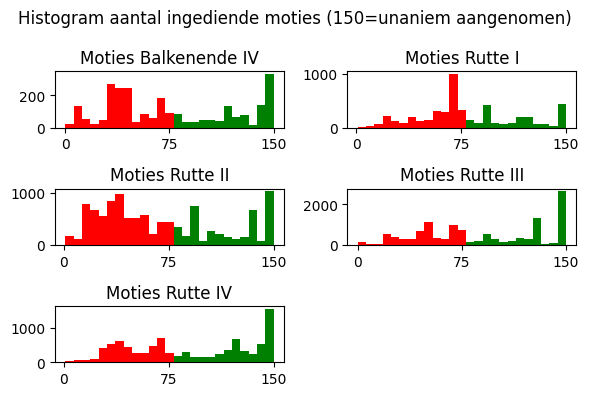

In [181]:
#| echo: false
# Set tick marks at every 75 units
tick_interval = 75

# Determine the common y-axis limits based on all histogram data
y_min = 0
y_max = 2800

# Create separate subplots for each Kamer category in a 2-column grid
num_categories = df['Kamer'].nunique()
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6, 4))

# Plot each histogram separately
for i, (category, group) in enumerate(df.groupby('Kamer')):
    row, col = i // num_cols, i % num_cols
    ax = axes[row, col]
    values = group['Voor']
    bins = 25
    _, bins, patches = ax.hist(values, bins=bins)
    ax.set_title('Moties '+ category)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=tick_interval))
    # ax.set_xlabel('Stemmen voor')
    # Set color for bars left from 75 as red
    # Set color for bars right from 75 as green
    for patch, left_edge in zip(patches, bins[:-1]):
        if left_edge < 75:
            patch.set_facecolor('red')
        else:
            patch.set_facecolor('green')

    # Set y-axis limits for all histograms
    # ax.set_ylim(y_min, y_max)

# Hide empty subplots if any
for i in range(num_categories, num_rows*num_cols):
    axes.flatten()[i].axis('off')

# Adjust layout and show the plot
fig.suptitle('Histogram aantal ingediende moties (150=unaniem aangenomen)')
plt.tight_layout()
plt.show()


In de histogrammen gaat het vooral om de verdeling van de moties tijdens de kamerperiodes. De rode moties hebben het niet gehaald, de groene wel.
* Rutte I: relatief veel moties die het nipt niet haalden
* Rutte II: veel afgewezen moties
* Rutte III: hele grote piek in het aantal unaniem aangenomen moties
* Rutte IV: lijken wel 4 verschillende types: oppositie vs regering, spannende moties, ruim aangenomen moties en unaniem aangenomen moties

In [182]:
a = df[df['Medeindiener_persoon'].apply(lambda x: len(x)) == 19]['Onderwerp'].iloc[0]
pprint.pprint(a)


('Motie van het lid Wassenberg c.s. over een onderzoek naar de mogelijkheid om '
 'het aantal proeven op niet-humane primaten verder te verlagen ')


In [183]:
#| echo: false
medeindieners = df['Medeindiener_persoon'].values
c = Counter(len(i) for i in medeindieners)
c.most_common()
source = pd.DataFrame(c.most_common()).rename(columns={0:'Aantal medeindieners',1:'Aantal moties'})
alt.Chart(source).mark_bar().encode(
    x=alt.X('Aantal medeindieners:O',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='Aantal moties:Q'
).properties(width=300, height=100)

alt.Chart(...)

Meestal worden moties ingediend door 1 partij, maar soms zijn er medeindieners. Er zijn twee moties met 19 medeindieners. [Onderzoek minder dierenproeven](https://www.tweedekamer.nl/kamerstukken/moties/detail?id=2022D49960&did=2022D49960), en [Inzien stukken Bijlmerramp](https://www.tweedekamer.nl/kamerstukken/moties/detail?id=2023D15968&did=2023D15968)

<!-- ## Komt elke partij opdagen? -->

In [184]:
#| include: false
# how many percent of moties did parties vote. Conclusion almost all
nan_per_party = df[stem_column].isnull().groupby([df['Kamer']]).sum()
count_per_chamber = df.groupby(['Kamer']).count()['Titel']
relevant_parties = ['Stem_'+p for p in get_largest_parties_chamber()]
1- np.divide(nan_per_party, count_per_chamber.values[:,None])[relevant_parties]

,Stem_VVD,Stem_D66,Stem_PVV,Stem_CDA,Stem_SP,Stem_PvdA,Stem_GroenLinks,Stem_PvdD,Stem_FVD,Stem_ChristenUnie,Stem_DENK,Stem_Groep Van Haga,Stem_JA21,Stem_SGP,Stem_Volt,Stem_BBB,Stem_Omtzigt,Stem_BIJ1,Stem_Fractie Den Haan,Stem_Gündogan
Kamer,,,,,,,,,,,,,,,,,,,,
Balkenende IV,1.000000,1.000000,0.985782,1.000000,1.000000,1.000000,1.000000,0.999605,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte I,0.999790,1.000000,1.000000,1.000000,1.000000,0.999790,0.999790,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte II,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rutte III,0.999097,0.999097,0.999097,0.999097,0.999097,0.999097,0.999097,0.999015,0.979964,0.999097,0.997701,0.000246,0.000411,0.999097,0.000411,0.000411,0.000082,0.000246,0.000246,0.000000
Rutte IV,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999334,0.999556,0.968361,0.998446,1.000000,0.999667,0.988899,0.777420,0.853797,0.929951,0.480018


In [185]:
#| include: false
# how many percent of votes did parties use. Conclusion almost all
relevant_parties = ['Aantal_stemmen_'+p for p in get_largest_parties(2022)]
mean_votes_per_party = df[relevant_parties+['Kamer']].replace(np.nan, 0).groupby('Kamer').mean()
max_votes_per_party = df[(relevant_parties+['Kamer'])].groupby('Kamer').quantile(.95)
np.divide(mean_votes_per_party, max_votes_per_party.values)

,Aantal_stemmen_VVD,Aantal_stemmen_D66,Aantal_stemmen_PVV,Aantal_stemmen_CDA,Aantal_stemmen_SP,Aantal_stemmen_PvdA,Aantal_stemmen_GroenLinks,Aantal_stemmen_PvdD,Aantal_stemmen_ChristenUnie,Aantal_stemmen_FVD,Aantal_stemmen_DENK,Aantal_stemmen_Groep Van Haga,Aantal_stemmen_JA21,Aantal_stemmen_SGP,Aantal_stemmen_Volt,Aantal_stemmen_BBB,Aantal_stemmen_Omtzigt,Aantal_stemmen_BIJ1,Aantal_stemmen_Fractie Den Haan,Aantal_stemmen_Gündogan
Kamer,,,,,,,,,,,,,,,,,,,,
Balkenende IV,0.998702,1.003028,0.987362,0.999345,0.999526,0.999988,1.000169,0.999605,0.999803,NaN,NaN,NaN,NaN,1.000197,NaN,NaN,NaN,NaN,NaN,NaN
Rutte I,0.999993,1.000126,0.987551,0.999760,1.000000,0.999958,0.999413,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000315,NaN,NaN,NaN,NaN,NaN,NaN
Rutte II,0.986981,0.999876,0.854382,1.000000,1.000000,0.966944,0.999605,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Rutte III,0.985309,0.999196,0.997159,0.999006,0.998950,0.999097,0.998921,0.906077,0.999097,0.980826,0.997701,0.000246,0.000411,0.999097,0.000411,0.000411,0.000082,0.000246,0.000246,NaN
Rutte IV,1.000000,0.996993,1.000000,0.943095,1.000000,0.992093,1.000000,0.998853,0.999334,1.018983,0.999556,0.968361,0.998446,1.000000,0.791815,0.988899,0.777420,0.853797,0.929951,0.480018


## Welke partij is de 'tegenpartij'?

In [186]:
#| include: false
test =pd.melt(df[stem_column  + ['Kamer']].replace(np.nan, 0.5).groupby('Kamer').mean().reset_index(), id_vars=['Kamer'],value_vars = stem_column, var_name='partij', value_name='percentage voorgestemd' )
test['partij'] = test['partij'].str[5:]
source = test[(test['Kamer']=='Rutte IV') & test['partij'].isin(parties)]

In [187]:
#| echo: false
chart = alt.Chart(source).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="percentage voorgestemd", op="sum", order='descending')),
    y=alt.Y('percentage voorgestemd:Q',axis=alt.Axis(format='%')),
    color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
).configure_axis(
        grid=False).configure_view(
        strokeWidth=1).properties(width=300, height=150)
chart.encoding.y.title = 'moties voorgestemd'
chart

alt.Chart(...)

De oppositie steunt de meeste moties, terwijl de regering vaak tegen stemt.

## Welke partijen dienen het meeste moties in en hoe succesvol zijn ze?

In [188]:
#| include: false
number_of_parties = 18
aantal_moties = df.groupby(['Kamer','Indienende_partij']).count()['Titel'].reset_index()
aantal_moties.rename(columns={'Titel':'aantal'}, inplace=True)
aantal_succesvol = df[df['BesluitSoort']==1].groupby(['Kamer','Indienende_partij']).count()['Titel'].reset_index()
aantal_succesvol.rename(columns={'Titel':'aantal_succesvol'}, inplace=True)
aantal_niet_succesvol = df[df['BesluitSoort']==0].groupby(['Kamer','Indienende_partij']).count()['Titel'].reset_index()
aantal_niet_succesvol.rename(columns={'Titel':'aantal_niet_succesvol'}, inplace=True)
max_votes_per_party = df[(['Aantal_stemmen_'+p for p in get_largest_parties_chamber('Rutte IV',number_of_parties)]+['Kamer'])].groupby('Kamer').quantile(.95)
max_votes_per_party = pd.melt(max_votes_per_party, ignore_index=False).reset_index()
max_votes_per_party = max_votes_per_party.rename(columns={'variable':'Indienende_partij', 'value':'num_votes'})
max_votes_per_party['Indienende_partij'] = max_votes_per_party['Indienende_partij'].str[15:]
stats = aantal_moties.merge(aantal_succesvol).merge(aantal_niet_succesvol).merge(max_votes_per_party)

In [189]:
#| include: false
stats['aantal_per_zetel'] = stats['aantal'] / stats['num_votes']
stats['aantal_succesvol_per_zetel'] = stats['aantal_succesvol'] / stats['num_votes']
stats['aantal_niet_succesvol_per_zetel'] = stats['aantal_niet_succesvol'] / stats['num_votes']
stats.rename(columns={'Indienende_partij':'partij'}, inplace=True)
stats = pd.melt(stats, id_vars=['Kamer', 'partij'],var_name='stat' )

In [190]:
# normalize by year
def get_chamber_period_year(chamber):
    return (chambers[chamber].end - chambers[chamber].start).days / 365
get_chamber_period_year('Rutte IV')
stats['DivisionFactor'] = stats['Kamer'].apply(get_chamber_period_year)
stats['value'] = stats['value'] / stats['DivisionFactor']

In [191]:
def add_zero_for_not_existing_parties(data, metric_of_interest):
    # Step 1: Get all unique partij and Kamer
    all_partij = data['partij'].unique()
    all_Kamer = data['Kamer'].unique()

    # Step 2: Generate all combinations of partij and Kamer
    all_combinations = list(itertools.product(all_partij, all_Kamer))

    # Step 3: Merge the original DataFrame with generated combinations and fill missing values with 0
    full_df = pd.DataFrame(all_combinations, columns=['partij', 'Kamer'])
    # full_df['stat'] = 
    full_df = full_df.merge(data, on=['partij', 'Kamer'], how='left')
    full_df['stat'] = metric_of_interest
    full_df['value'] = full_df['value'].fillna(0).astype(int)
    
    return full_df


In [192]:

#| echo: false
# Step 1: create the line
metric_of_interest = 'aantal_succesvol'
data = stats[stats['stat'] == metric_of_interest].copy()
relevant_parties = list(reversed(get_largest_parties_chamber(top=number_of_parties)))
data['partij'] = pd.Categorical(data['partij'], relevant_parties)
data = data.sort_values(by='partij',ascending=False)
data = add_zero_for_not_existing_parties(data, metric_of_interest)
area = alt.Chart(data).mark_area(interpolate="monotone").encode(
    x='Kamer:O',
    y=alt.Y("value:Q", stack='zero'),
    order='order:O',
    tooltip=['partij:N'],
    color=alt.Color("partij",scale = alt.Scale(domain=relevant_parties,range= [party_colors[p] for p in (relevant_parties)])))

area.encoding.y.title = 'Aantal succesvolle moties per jaar'

chart = alt.layer(area, width=300)
chart


alt.LayerChart(...)

In bovenstaande grafiek zijn de partijen op elkaar gestapeld. Het aantal succesvolle moties is sterk gestegen.

In [193]:
#| echo: false
chart = alt.Chart(stats).mark_bar().encode(
    column='Kamer',
    x='value:Q',
    
    y=alt.Y('partij:N', sort=list(parties)),
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvol','aantal_niet_succesvol'],
        range=['green', 'red']),
        legend=alt.Legend(orient="top"))
).properties(width=60).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvol','aantal_niet_succesvol']))
chart.encoding.x.title = 'Moties per jaar'
chart

alt.Chart(...)

Deze visualisatie geeft weer hoeveel partijen (niet) succesvol zijn ingediend tijdens de verschillende kamerperiodes. Je ziet bijvoorbeeld PVV en SP als partijen met veel moties, maar weinig succesvolle. Ook worden de moties van regeringspartijen vaker aangenomen. Dit komt natuurlijk doordat ze met de regeringspartijen een meerderheid hebben. Laten we nu kijken hoe deze grafiek eruit ziet per zetel, om een 'productiviteit' per zetel te meten.

In [194]:
#| echo: false
chart = alt.Chart(stats).mark_bar().encode(
    column='Kamer',
    x='value:Q',
    y=alt.Y('partij:N', sort=list(parties)),
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvol_per_zetel','aantal_niet_succesvol_per_zetel'],
        range=['green', 'red']),
        legend=alt.Legend(orient="top"))
).properties(width=60).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvol_per_zetel','aantal_niet_succesvol_per_zetel']))
chart.encoding.x.title = 'Moties per jaar'
chart

alt.Chart(...)

Opvallend is het hoge aantal moties van BBB per zetel. Bij de VVD en D66 valt het lage aantal moties per zetel op. Dit zijn natuurlijk ook de regeringspartijen met het hoogste aantal zetels.

## Wie zijn de 'motiekanonnen' van de Tweede Kamer?

Wie is nu het meest 'succesvolle' kamerlid?
* De Producent: Wiebren van Haga diende maar liefst 191 moties in per jaar, hierbij blijft hij Caroline vd Plas nipt voor (183 per jaar).
* De Winnaar: Pieter Grinwis van de ChristenUnie. Met 85 aangenomen moties het succesvolst. Caroline vd Plas (BBB) staat op plek twee met 50 successen per jaar, op de voet gevolgd door Stephan van Baarle (DENK) (44). 
* De Samenwerker: Kijken we naar de politicus die het meeste moties heeft mede-ingediend staat Caroline vd Plas maar liefst 254 keer als mede-indiener vermeld.

In [195]:
#| include: false
for chamber in chambers:
    indieners = df[(df['Kamer'] == chamber)]['Indienende_persoon_partij'].values
    c = Counter(indieners)
    highest = c.most_common(10)
    highest = [(name, round(number/chambers[chamber].numyears)) for name, number in highest]
    print(f'\nMeeste moties per jaar, {chamber}')
    pprint.pprint(highest)


Meeste moties per jaar, Balkenende IV
[('E. Ouwehand, PvdD', 57),
 ('H.P.J. van Gerven, SP', 43),
 ('W. van Gent, GroenLinks', 41),
 ('M.L. Thieme, PvdD', 41),
 ('K. van Velzen, SP', 39),
 ('E.G.M. Roemer, SP', 37),
 ('H. Brinkman, PVV', 34),
 ('A. Pechtold, D66', 33),
 ('S.R. Fritsma, PVV', 33),
 ('D.J.G. Graus, PVV', 32)]

Meeste moties per jaar, Rutte I
[('E. Ouwehand, PvdD', 84),
 ('H.P.J. van Gerven, SP', 77),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 63),
 ('S. van Veldhoven, D66', 52),
 ('J.S. Voordewind, ChristenUnie', 49),
 ('A. Slob, ChristenUnie', 44),
 ('J.J. (Jasper) van Dijk, SP', 40),
 ('R.M. Leijten, SP', 39),
 ('L. Jacobi, PvdA', 39),
 ('W. van Gent, GroenLinks', 38)]

Meeste moties per jaar, Rutte II
[('R.K. Dik-Faber, ChristenUnie', 81),
 ('L. van Tongeren, GroenLinks', 76),
 ('E. Ouwehand, PvdD', 69),
 ('S. van Veldhoven, D66', 57),
 ('H.P.J. van Gerven, SP', 56),
 ('L.G.J. Voortman, GroenLinks', 54),
 ('D.J.G. Graus, PVV', 50),
 ('R.M. Leijten, SP', 4

In [196]:
#| include: false
for chamber in chambers:
    indieners = df[(df['Kamer'] == chamber) & (df['BesluitSoort']==1)]['Indienende_persoon_partij'].values
    c = Counter(indieners)
    highest = c.most_common(10)
    highest = [(name, round(number/chambers[chamber].numyears)) for name, number in highest]
    print(f'\nMeeste succesvolle moties per jaar, {chamber}')
    pprint.pprint(highest)


Meeste succesvolle moties per jaar, Balkenende IV
[('E.A. Cramer, ChristenUnie', 20),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 19),
 ('B. van der Ham, D66', 17),
 ('J.J. Atsma, CDA', 16),
 ('J.S. Voordewind, ChristenUnie', 16),
 ('W. van Gent, GroenLinks', 16),
 ('G.P.J. Koopmans, CDA', 15),
 ('C.A. Ortega-Martijn, ChristenUnie', 15),
 ('E.W. Anker, ChristenUnie', 14),
 ('M. Peters, GroenLinks', 14)]

Meeste succesvolle moties per jaar, Rutte I
[('S. van Veldhoven, D66', 26),
 ('G.P.J. Koopmans, CDA', 22),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 21),
 ('A. Slob, ChristenUnie', 18),
 ('J.S. Voordewind, ChristenUnie', 18),
 ('S. de Rouwe, CDA', 17),
 ('L. Jacobi, PvdA', 16),
 ('E. Ouwehand, PvdD', 16),
 ('H.P.J. van Gerven, SP', 15),
 ('C.G. van der Staaij, SGP', 15)]

Meeste succesvolle moties per jaar, Rutte II
[('R.K. Dik-Faber, ChristenUnie', 38),
 ('S. van Veldhoven, D66', 35),
 ('L. van Tongeren, GroenLinks', 24),
 ('V.A. Bergkamp, D66', 20),
 ('L.G.J.

In [197]:
#| include: false
for chamber in chambers:
    medeindieners = df[(df['Kamer'] == chamber)]['Medeindiener_persoon'].values
    c = Counter(x for i in medeindieners for x in i)
    highest = c.most_common(10)
    highest = [(name, round(number/chambers[chamber].numyears)) for name, number in highest]
    print(f'\nMeeste moties mede-ingediend per jaar, {chamber}')
    pprint.pprint(highest)


Meeste moties mede-ingediend per jaar, Balkenende IV
[('W. van Gent', 65),
 ('B.J. van der Vlies', 52),
 ('A. Pechtold', 42),
 ('E.E. Wiegman-van Meppelen Scheppink', 42),
 ('T. Dibi', 39),
 ('B. van der Ham', 38),
 ('C.C.M. Vendrik', 37),
 ('E.A. Cramer', 35),
 ('C.G. van der Staaij', 33),
 ('F. Koser Kaya', 32)]

Meeste moties mede-ingediend per jaar, Rutte I
[('E.E. Wiegman-van Meppelen Scheppink', 93),
 ('L.G.J. Voortman', 81),
 ('J.S. Voordewind', 63),
 ('S. van Veldhoven', 61),
 ('L. Jacobi', 57),
 ('C.G. van der Staaij', 53),
 ('B.A.M. Braakhuis', 48),
 ('E. Ouwehand', 45),
 ('E. Dijkgraaf', 44),
 ('W. van Gent', 44)]

Meeste moties mede-ingediend per jaar, Rutte II
[('R.K. Dik-Faber', 71),
 ('L. van Tongeren', 70),
 ('S. van Veldhoven', 64),
 ('L.G.J. Voortman', 56),
 ('J.S. Voordewind', 49),
 ('C.G. van der Staaij', 48),
 ('E. Dijkgraaf', 43),
 ('A.H. (Agnes) Mulder', 38),
 ('G.J.M. Segers', 38),
 ('J.J. (Jasper) van Dijk', 37)]

Meeste moties mede-ingediend per jaar, Rutte I

## Welke partijen werken samen?

In [198]:
#| include: false
medeindiener_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c and c != 'Indiener_persoon']
    medeindieners = [c for c in moties_in_year.columns if 'Medeindiener' in c and c != 'Medeindiener_persoon']
    stem = ['Stem_'+c[13:] for c in medeindieners]
    assert len(stem) == len(medeindieners)
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)]
        print(chamber, partij_moties[medeindieners].sum(), p,partij_moties[stem].notna().sum().values)
        if min(partij_moties[stem].notna().sum().values) == 0:
            continue
        res = (partij_moties[medeindieners].sum() / partij_moties[stem].notna().sum().values)
        res = pd.DataFrame({'support':res.index.str[13:],'percentage':res.values, 'mede':partij_moties[medeindieners].sum(), 'stem':partij_moties[stem].notna().sum().values})
        res['partij'] = p[9:]
        res['kamer']= chamber
        # how often did the party cosign & vote / how often did the party vote
        res2 =partij_moties[medeindieners].values * partij_moties[stem].values
        res2 = pd.DataFrame({'support': [s[5:] for s in stem], 'percentage':np.nansum(res2, axis=0)/partij_moties[stem].notna().sum().values})
        res2['partij']= p[9:]
        res2['kamer']= chamber
        medeindiener_perc = pd.concat([medeindiener_perc, res2], ignore_index=True)    

Balkenende IV Medeindiener_CDA               9
Medeindiener_ChristenUnie    116
Medeindiener_D66              20
Medeindiener_GroenLinks       28
Medeindiener_PVV              10
Medeindiener_PvdA            170
Medeindiener_PvdD              3
Medeindiener_SGP              42
Medeindiener_SP               34
Medeindiener_VVD              86
Medeindiener_Verdonk           1
dtype: object Indiener_CDA [305 305 305 305 301 305 305 305 305 305 279]
Balkenende IV Medeindiener_CDA             62
Medeindiener_ChristenUnie     3
Medeindiener_D66              9
Medeindiener_GroenLinks      24
Medeindiener_PVV              0
Medeindiener_PvdA            74
Medeindiener_PvdD             1
Medeindiener_SGP             19
Medeindiener_SP              15
Medeindiener_VVD             12
Medeindiener_Verdonk          0
dtype: object Indiener_ChristenUnie [140 140 140 140 138 140 140 140 140 140 121]
Balkenende IV Medeindiener_CDA             12
Medeindiener_ChristenUnie     3
Medeindiener_D66        

Rutte III Medeindiener_50PLUS                2
Medeindiener_CDA                   1
Medeindiener_ChristenUnie          0
Medeindiener_D66                   1
Medeindiener_DENK                  1
Medeindiener_FVD                   2
Medeindiener_GroenLinks            1
Medeindiener_Groep Krol/vKA        1
Medeindiener_Krol                  0
Medeindiener_PVV                   1
Medeindiener_PvdA                  2
Medeindiener_PvdD                  0
Medeindiener_SGP                   0
Medeindiener_SP                    3
Medeindiener_VVD                   0
Medeindiener_Van Haga              1
Medeindiener_Van Kooten-Arissen    0
dtype: object Indiener_Groep Krol/vKA [13 13 13 13 13 13 13 13  0 13 13 13 13 13 13 13  0]
Rutte III Medeindiener_50PLUS                0
Medeindiener_CDA                   0
Medeindiener_ChristenUnie          0
Medeindiener_D66                   0
Medeindiener_DENK                  1
Medeindiener_FVD                   3
Medeindiener_GroenLinks            0
M

In [199]:
#| include: false
# There are some cases where a party is submitting a moties but not voting on it, see below example
# https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z22006&did=2020D46879

In [200]:
#| echo: false
medeindiener_perc = medeindiener_perc[medeindiener_perc['support'].isin(parties)]
medeindiener_perc = medeindiener_perc[medeindiener_perc['partij'].isin(parties)]

chart = alt.Chart(medeindiener_perc).mark_rect().encode(
    x=alt.X('partij:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'),
    legend=alt.Legend(orient="right",format='%'))
).transform_filter(alt.FieldOneOfPredicate(field='kamer', oneOf=['Rutte IV'])).properties(height=200,width=200)

chart.encoding.y.title = 'mede-ingediend door'
chart.encoding.x.title = 'motie ingediend door'
chart

alt.Chart(...)

Duidelijk is hier te zien dat de regeringspartijen vaak samen moties indienen. De innige samenwerking tussen GroenLinks en PvdA is ook mooi te zien.

In [201]:
#| include: false
chart = alt.Chart(medeindiener_perc,height=150,width=80).mark_rect().encode(
    column='partij:N',
    x=alt.X('kamer:N'),
    y=alt.Y('support:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'),
    legend=alt.Legend(orient="right",format='%')))
chart.encoding.y.title = 'medeingediende door'
chart

alt.Chart(...)

#| include: false
Hier zijn weer heel mooi de effecten te zien van in de regering zitten. Opvallend:
- Samenwerking Groenlinks en PvdA is verder geintensiveerd
- Een aantal partijen heeft vrijwel nooit medeindieners

In [202]:
#| include: false
stem_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    stem = [c for c in moties_in_year.columns if 'Stem' in c][1:]
    
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)] 
        
        partij_moties = partij_moties.replace(-1,0)
        res = (partij_moties[stem].sum()/partij_moties[stem].notna().sum())
        res = pd.DataFrame({'support':res.index.str[5:],'percentage':res.values})
        res['partij']= p[9:]
        res['kamer'] = chamber
        stem_perc = pd.concat([stem_perc, res], ignore_index=True)    
        

In [203]:
#| echo: false
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]

chart = alt.Chart(stem_perc).mark_rect().encode(
    column = 'kamer',
    x=alt.X('partij:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'),
    legend=alt.Legend(orient="right",format='%'))
).transform_filter(alt.FieldOneOfPredicate(field='kamer', oneOf=['Rutte IV'])).properties(width=200, height=200)
chart.encoding.y.title = 'gesteund door'
chart.encoding.x.title = 'moties van partij'
chart

alt.Chart(...)

Hier zie je mooi een paar groepen die elkaar veel steunen. FVD krijgt onder de regering en 'normale oppositie' nauwelijks steun.

In [204]:
#| include: false
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]

chart = alt.Chart(stem_perc,height=150,width=80).mark_rect().encode(
    column = 'partij',
    x=alt.X('kamer:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'),legend=alt.Legend(orient="right",format='%'))
)
chart.encoding.y.title = 'gesteund door'
chart

alt.Chart(...)

## Welke partijen lijken het meeste op elkaar qua stemgedrag?

In [214]:
#| include: false
chamber = 'Rutte IV'
num_largest = 18
source = get_pca(df, n_components = 1, chamber = chamber, num_largest = num_largest)
# this variable will be used throughout the notebook!
parties = list(get_largest_parties_chamber(chamber,num_largest))

PCA results for Rutte IV
explained variance by factors [0.33496735] 0.3349673498017803


In [222]:
#| echo: false
alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="x", op="sum", order='ascending')),
    y=alt.Y('x:Q', axis = None),
    color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
).configure_axis(
        grid=False).configure_view(
        strokeWidth=1).properties(width=300)

alt.Chart(...)

In bovenstaande grafiek is het stemgedrag van alle partijen platgeslagen op één as met een Principal Component Analaysis. Deze as verklaart 33% van het stemgedrag en is dus verre van compleet. Of de bar positief of negatief is maakt niet uit, het gaat erom dat vergelijkbare partijen bij elkaar in de buurt liggen. Kennelijk liggen FVD en Groenlinks het meest van elkaar verwijderd. 

Hieronder visualiseren we het stemgedrag op twee assen. Op deze manier kunnen zo'n 60% van het stemgedrag beschrijven (niet 100%!). Als twee partijen vlak bij elkaar liggen wil dus niet zeggen dat ze altijd hetzelfde stemmen. De horizontale as is groter omdat deze meer van het stemgedrag verklaart.

In [235]:
#| include: false
def get_pca_chart(source, explained_variance_ratio, size=500/0.35):
    points = alt.Chart(source,width= size * explained_variance_ratio_[0],height = size * explained_variance_ratio_[1]).mark_point().encode(
        # x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
        # y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
        x=alt.X('x:Q', axis=None),
        y=alt.Y('y:Q', axis=None),
        color=alt.Color("partij",scale = alt.Scale(domain=relevant_parties,range= [party_colors[p] for p in (relevant_parties)]), legend=None),
        
        tooltip=['partij:N']
    )

    text = points.mark_text(
        align='left',
        baseline='middle',
        dx=np.random.uniform(0,10),
        dy=np.random.uniform(0,10),
        size=16
        # opacity=0.5
    ).encode(
        text='partij:N'
    ).properties(
        title='Welke partijen lijken op elkaar'
    )

    return (points + text).configure_axis(
        grid=False).configure_view(
        strokeWidth=1)
    
charts = []
for chamber in chambers:
    num = 18 if chamber == 'Rutte IV' else 13
    
    source, explained_variance_ratio_ = get_pca(df, n_components = 2, chamber = chamber, num_largest = num, return_ratio=True)
    mid = (source['x'].max() + source['x'].min())/2
    if chamber != 'Rutte IV':
        if source[source['partij'] =='VVD']['x'].values < mid: # make sure that VVD is on the right part of the x-axis
            source['x'] += 2 * (mid - source['x'])
    print(explained_variance_ratio_, sum(explained_variance_ratio_))
    chart = get_pca_chart(source, explained_variance_ratio_)
    charts.append(chart)

PCA results for Balkenende IV
explained variance by factors [0.35175622 0.25215805] 0.6039142701445464
[0.35175622 0.25215805] 0.6039142701445464
PCA results for Rutte I
explained variance by factors [0.43854584 0.16639527] 0.6049411063496632
[0.43854584 0.16639527] 0.6049411063496632
PCA results for Rutte II
explained variance by factors [0.32341984 0.17251486] 0.49593469769969833
[0.32341984 0.17251486] 0.49593469769969833


d:\Programmeren\adventofcode\.aocenvpy311\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['2018Z21787' '2019Z24714' '2019Z24718' '2019Z24722' '2019Z24720'
 '2019Z24719' '2019Z24723' '2019Z24713' '2019Z24724' '2019Z24721'
 '2020Z21044']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


PCA results for Rutte III
explained variance by factors [0.44276158 0.20752043] 0.650282003993176
[0.44276158 0.20752043] 0.650282003993176
PCA results for Rutte IV
explained variance by factors [0.33496735 0.23364411] 0.5686114548616158
[0.33496735 0.23364411] 0.5686114548616158


In [236]:
#| include: false
charts[0].properties(title='Vergelijkbaarheid stemgedrag: Balkenende IV')

alt.LayerChart(...)

In [237]:
#| include: false
charts[1].properties(title='Vergelijkbaarheid stemgedrag: Rutte I')

alt.LayerChart(...)

In [238]:
#| include: false
charts[2].properties(title='Vergelijkbaarheid stemgedrag: Rutte II')

alt.LayerChart(...)

In [239]:
#| echo: false
charts[3].properties(title='Vergelijkbaarheid stemgedrag: Rutte III')

alt.LayerChart(...)

In [240]:
charts[4].properties(title='Vergelijkbaarheid stemgedrag: Rutte IV')

alt.LayerChart(...)

Er zijn grofweg 3 clusters te onderscheiden: 
* de regeringspartijen bovenaan
* Het linkerdeel van de oppositie linksonder
* Het (extreen) rechtse gedeelte van de oppositie rechtsonder

In een volgend blog bekijk ik de inhoud van de moties. Kijken of er trends zijn in onderwerpen en welke partij het meest actief is op bepaalde onderwerpen.

:::{.callout-note}

Ik heb enkele visualisaties in de blog achterwege gelaten om het nog enigzins leesbaar te houden. Op [GitHub](https://github.com/jvanelteren/blog/tree/master/_notebooks/2021-02-20-kamermotiesEDA.ipynb)

:::